In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import os
import argparse
import numpy as np

from fastprogress.fastprogress import master_bar, progress_bar


from pprint import pprint as pp
from scipy import linalg
from copy import deepcopy

from utils import FlowLayout
import seaborn as sns
import matplotlib.pyplot as plt

print('#GPU: ', torch.cuda.device_count())
print('PyTorch Version:', torch.__version__)
np.set_printoptions(precision=2)

#GPU:  1
PyTorch Version: 1.6.0a0+b0b9e70


In [2]:
# Preparing data..
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='/dev/shm', train=True, download=True, transform=transform_train)


testset = torchvision.datasets.CIFAR10(
    root='/dev/shm', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [3]:
# define the model

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x, aux_output=False):
        # out = self.features(x)
        out = self.features[0](x)
        out = self.features[1](out)
        out = self.features[2](out)
        block0_out, idx03 = self.features[3](out)
        
        out = self.features[4](block0_out)
        out = self.features[5](out)
        out = self.features[6](out)
        block1_out, idx07 = self.features[7](out)
        
        out = self.features[8](block1_out)
        out = self.features[9](out)
        block2_out = self.features[10](out)
        
        out = self.features[11](block2_out)
        out = self.features[12](out)
        out = self.features[13](out)
        block3_out, idx14 = self.features[14](out)
        
        out = self.features[15](block3_out)
        out = self.features[16](out)
        block4_out = self.features[17](out)
        
        out = self.features[18](block4_out)
        out = self.features[19](out)
        out = self.features[20](out)
        block5_out, idx21 = self.features[21](out)
        
        out = self.features[22](block5_out)
        out = self.features[23](out)
        block6_out = self.features[24](out)
        
        out = self.features[25](block6_out)
        out = self.features[26](out)
        out = self.features[27](out)
        block7_out, idx28 = self.features[28](out)
        
        out = self.features[29](block7_out)
        
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        
        if aux_output:
            return out, [block7_out, block6_out, block5_out, block4_out, 
                         block3_out, block2_out, block1_out, block0_out, x]
        else:
            return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=False)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

device='cuda'
net = VGG('VGG11').to(device)

out, aux_out = net(torch.randn(1,3,32,32).cuda(), True)
print([i.size() if i is not None else None for i in aux_out])

[torch.Size([1, 512, 1, 1]), torch.Size([1, 512, 2, 2]), torch.Size([1, 512, 2, 2]), torch.Size([1, 512, 4, 4]), torch.Size([1, 256, 4, 4]), torch.Size([1, 256, 8, 8]), torch.Size([1, 128, 8, 8]), torch.Size([1, 64, 16, 16]), torch.Size([1, 3, 32, 32])]


In [4]:
def test(net, testloader):
    criterion = nn.CrossEntropyLoss()
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    final_loss = test_loss/(batch_idx+1)
    acc = 100.*correct/total
    return final_loss, acc


# for epoch in range(start_epoch, start_epoch+epochs):
#     train(epoch)
#     test(epoch)
#     scheduler.step()

checkpoint = torch.load('./cifar_vgg_11.pth')
net.load_state_dict(checkpoint['net'])


        
def InpSizeHook(module, input, output):
    module.inp_size = input[0].size()
    
for n,m in net.named_modules():
    if n!='' and n!='features':
        m.register_forward_hook(InpSizeHook)
    
test(net, testloader)

(0.46780923235265515, 89.69)

In [5]:
for n,m in net.named_modules():
    if n!='' and n!='features':
        print(n,'||',m, '||',m.inp_size)
        # print()
        # if '9' in n:
        #     break

features.0 || Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) || torch.Size([16, 3, 32, 32])
features.1 || BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) || torch.Size([16, 64, 32, 32])
features.2 || ReLU() || torch.Size([16, 64, 32, 32])
features.3 || MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) || torch.Size([16, 64, 32, 32])
features.4 || Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) || torch.Size([16, 64, 16, 16])
features.5 || BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) || torch.Size([16, 128, 16, 16])
features.6 || ReLU() || torch.Size([16, 128, 16, 16])
features.7 || MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) || torch.Size([16, 128, 16, 16])
features.8 || Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) || torch.Size([16, 128, 8, 8])
features.9 || BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

In [6]:
class InvVGG(nn.Module):
    def __init__(self):
        super(InvVGG, self).__init__()
        
        self.inv_block0 = self._make_layer(64, 3, True, ifblock0=True) 
        self.inv_block1 = self._make_layer(128, 64, True)
        self.inv_block2 = self._make_layer(256, 128, False)
        self.inv_block3 = self._make_layer(256, 256, True)
        self.inv_block4 = self._make_layer(512, 256, False)
        self.inv_block5 = self._make_layer(512, 512, True)
        self.inv_block6 = self._make_layer(512, 512, False)
        self.inv_block7 = self._make_layer(512, 512, True)
        self.inv_classifier = nn.Sequential(nn.Linear(10, 256),
                                            nn.ReLU(inplace=False),
                                            nn.Linear(256, 512),
                                            nn.ReLU(inplace=False))
        
        
        self.all_layers = [[self.inv_classifier], 
                           self.inv_block7, self.inv_block6, self.inv_block5, self.inv_block4, 
                           self.inv_block3, self.inv_block2, self.inv_block1, self.inv_block0 ]
        
    def forward(self, out, idx):
        layers = self.all_layers[idx:]
        aux_output = [None for _ in range(9)]
        for l_idx, l in enumerate(layers):
            if isinstance(l, list):
                out = l[0](out)
                out = out.view(-1, 512, 1, 1)
            else:
                out = l(out)
            # aux_output[l_idx] = out 
        return out, aux_output
    
    def onelayer_forward(self, out, idx):
        if idx==0:
            layer = self.all_layers[idx][0]
            inp = layer(out).view(-1, 512, 1, 1)
        else:
            layer = self.all_layers[idx]
            inp = layer(out)
        return inp
    
    def _make_layer(self, in_channel, out_channel, upsample, ifblock0=False):
        layers = []
        if upsample:
            layers += [nn.ConvTranspose2d(in_channel, in_channel, 
                                          kernel_size=2, stride=2, padding=0)]
        else:
            layers += [nn.ConvTranspose2d(in_channel, in_channel, 
                                          kernel_size=3, stride=1, padding=1)]
            
        layers += [nn.BatchNorm2d(in_channel, affine=True)]
        layers += [nn.LeakyReLU(inplace=False, negative_slope=0.2)]
        layers += [nn.ConvTranspose2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1)]
        if not ifblock0:
            layers += [nn.ReLU(inplace=False)]
        return nn.Sequential(*layers)  
    
inv_net = InvVGG()

# check the output size
out, aux_out = inv_net(torch.randn(1, 10), 0)
print([i.size() if i is not None else None for i in aux_out])
print(out.size())

[None, None, None, None, None, None, None, None, None]
torch.Size([1, 3, 32, 32])


In [7]:
def test_quality_inverted(idx_block):
    net.eval()
    inv_net.eval()

    correct_comp_net = 0
    correct_comp_targets = 0

    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, block_outputs = net(inputs, True)
            if idx_block==0:
                inverted_image, _ = inv_net(outputs, idx_block)
            else:
                inverted_image, _ = inv_net(block_outputs[idx_block-1], idx_block)
            outputs_from_inverted = net(inverted_image, False)

            _, predicted_from_inverted = outputs_from_inverted.max(1)
            _, predicted = outputs.max(1)

            total += targets.size(0)
            correct_comp_net     += predicted_from_inverted.eq(predicted).sum().item()
            correct_comp_targets += predicted_from_inverted.eq(targets).sum().item()

        print('==>Inv Block: %d | Acc (Comp with net)    : %.3f'%(8-idx_block, 100.*correct_comp_net/total))
        print('==>Inv Block: %d | Acc (Comp with targets): %.3f'%(8-idx_block, 100.*correct_comp_targets/total))

In [8]:
# import glob

# file_list = glob.glob('/myws/codes/Octopy/quant_fl/cifar10_di_onownvgg_saved/*.pt')

# di_tensor_list = []
# for n in file_list[:500]:
#     di_tensor_list.append(torch.load(n))
    
# di_dataset = torch.utils.data.TensorDataset(torch.cat(di_tensor_list), torch.cat(di_tensor_list))
# di_loader  = torch.utils.data.DataLoader(di_dataset, batch_size=256, shuffle=True, num_workers=8)

===> 8


----------------------------------------
Inverting the block: Sequential(
  (0): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


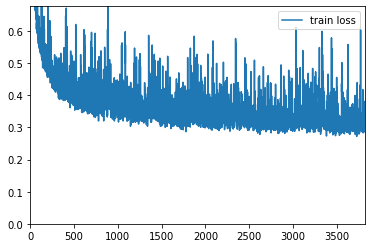

==>Inv Block: 0 | Acc (Comp with net)    : 94.470
==>Inv Block: 0 | Acc (Comp with targets): 87.480
===> 7


----------------------------------------
Inverting the block: Sequential(
  (0): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
)


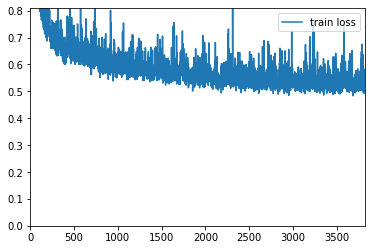

==>Inv Block: 1 | Acc (Comp with net)    : 90.270
==>Inv Block: 1 | Acc (Comp with targets): 84.690
===> 6


----------------------------------------
Inverting the block: Sequential(
  (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
)


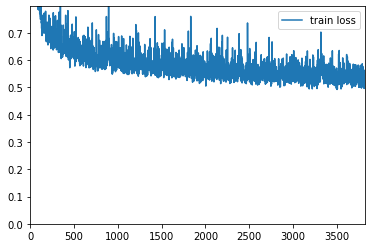

==>Inv Block: 2 | Acc (Comp with net)    : 90.740
==>Inv Block: 2 | Acc (Comp with targets): 85.280
===> 5


----------------------------------------
Inverting the block: Sequential(
  (0): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
)


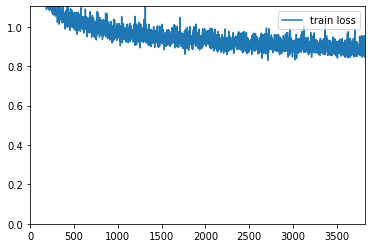

==>Inv Block: 3 | Acc (Comp with net)    : 86.920
==>Inv Block: 3 | Acc (Comp with targets): 82.510
===> 4


----------------------------------------
Inverting the block: Sequential(
  (0): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
)


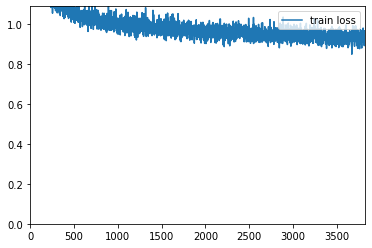

==>Inv Block: 4 | Acc (Comp with net)    : 87.880
==>Inv Block: 4 | Acc (Comp with targets): 83.580
===> 3


----------------------------------------
Inverting the block: Sequential(
  (0): ConvTranspose2d(512, 512, kernel_size=(2, 2), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
)


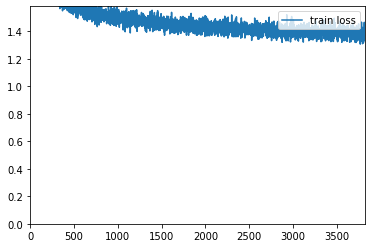

==>Inv Block: 5 | Acc (Comp with net)    : 86.330
==>Inv Block: 5 | Acc (Comp with targets): 82.290
===> 2


----------------------------------------
Inverting the block: Sequential(
  (0): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
)


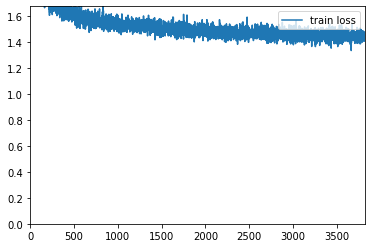

==>Inv Block: 6 | Acc (Comp with net)    : 87.110
==>Inv Block: 6 | Acc (Comp with targets): 83.270
===> 1


----------------------------------------
Inverting the block: Sequential(
  (0): ConvTranspose2d(512, 512, kernel_size=(2, 2), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
)


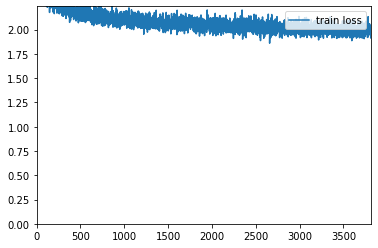

==>Inv Block: 7 | Acc (Comp with net)    : 93.860
==>Inv Block: 7 | Acc (Comp with targets): 87.740
===> 0


----------------------------------------
Inverting the block: Sequential(
  (0): Linear(in_features=10, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): ReLU()
)


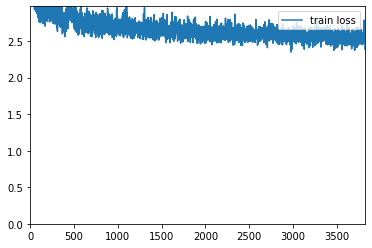

==>Inv Block: 8 | Acc (Comp with net)    : 98.720
==>Inv Block: 8 | Acc (Comp with targets): 89.590


In [9]:
trainloader = torch.utils.data.DataLoader(
                        trainset, batch_size=128, shuffle=True, num_workers=8)

net = net.to(device)
inv_net = inv_net.to(device)

epochs = 10
# criterion = nn.MSELoss()
criterion = nn.L1Loss()

saved_loss = []

for idx_block in reversed(range(9)):
    print('===> %d'%idx_block)
    if idx_block != 0:
        # continue
        pass
    # only update the top block of current inv model
    current_block = inv_net.all_layers[idx_block]
    current_block = current_block[0] if isinstance(current_block, list) else current_block
    print('\n')
    print('--'*20)
    print('Inverting the block:', current_block)
    
    optimizer = optim.Adam(inv_net.parameters(), lr=0.001)
    # optimizer = optim.Adam(inv_net.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0, last_epoch=-1)
    mb = master_bar(range(epochs))
    mb.names = ['train loss']
    all_train_loss = []
    
    net.eval()
    inv_net.train()
    for epoch_idx in mb:
        train_loss = 0
        for batch_idx, (inputs, targets) in enumerate(progress_bar(trainloader, parent=mb)):
            inputs, targets = inputs.to(device), targets.to(device)
            # inputs = torch.empty(128,3,32,32).cuda().normal_(mean=-0.32, std=1.40)
            inputs = (inputs + inputs[np.random.permutation(inputs.size(0))])*0.5
            inv_net.zero_grad()
            with torch.no_grad():
                outputs, block_outputs = net(inputs, True)
                
            # if idx_block==0:
            #     inverted = inv_net.onelayer_forward(outputs, idx_block)
            # else:
            #     inverted = inv_net.onelayer_forward(block_outputs[idx_block], idx_block)
            if idx_block==0:
                inverted_image, _ = inv_net(outputs, idx_block)
            else:
                inverted_image, _ = inv_net(block_outputs[idx_block-1], idx_block)
                
            inverted_outputs, inverted_block_outputs = net(inverted_image, True)

            assert inverted_image.size()==inputs.size()
            if idx_block==0:
                inverted_outputs.size() == outputs.size()
                inverted_imm = inverted_outputs
                imm          = outputs
            else:
                inverted_block_outputs[idx_block-1].size() == block_outputs[idx_block-1].size()
                inverted_imm = inverted_block_outputs[idx_block-1]
                imm          = block_outputs[idx_block-1]
            loss = 0
            loss += criterion(inverted_image, inputs)*3
            loss += criterion(inverted_imm, imm)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            all_train_loss.append(loss.item())

            if batch_idx%100==0:
                len_loss = len(all_train_loss)
                mb.update_graph([[range(len_loss), all_train_loss]], 
                                [0, len_loss], 
                                [0, max(all_train_loss[max(0, len_loss-3000):])])
            mb.child.comment = 'train loss: %.3e'%loss.item()
            
        mb.main_bar.comment = 'train loss: %.3e'%(train_loss/(batch_idx+1))
    scheduler.step()
        
    mb.write('train loss: %.3e'%(train_loss/(batch_idx+1)))
    saved_loss.append(deepcopy(all_train_loss))
    test_quality_inverted(idx_block)
    
# np.save('on_realtrain_saved_loss', saved_loss)

In [10]:
test_quality_inverted(0)

==>Inv Block: 8 | Acc (Comp with net)    : 98.720
==>Inv Block: 8 | Acc (Comp with targets): 89.590


In [11]:
import matplotlib.pyplot as plt
from di import denormalize

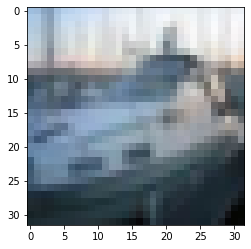

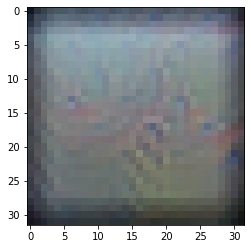

In [17]:


net.eval()
inv_net.eval()

correct_comp_net = 0
correct_comp_targets = 0

total = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs, block_outputs = net(inputs, True)
        inverted_image, _ = inv_net(outputs, 0)
        outputs_from_inverted = net(inverted_image, False)
        break

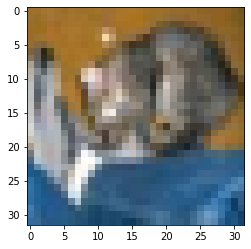

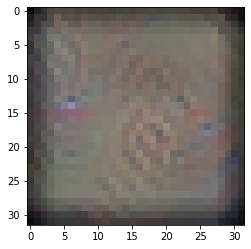

In [20]:
img_idx = 0

plt.figure()
plt.imshow(denormalize(inputs[img_idx].cpu()).view(3,-1).T.view(32,32,3))
plt.figure()
plt.imshow(denormalize(inverted_image[img_idx].cpu()).view(3,-1).T.view(32,32,3).detach())